# 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [2]:
!pip install konlpy > /dev/null

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", sep='\t')

In [8]:
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


## 데이터 전처리

In [11]:
# 중복 여부 확인
df.shape, df.document.nunique()

((200000, 3), 194543)

In [12]:
# 중복 데이터 배제
df.drop_duplicates(subset=['document'], inplace=True)
df.shape

(194544, 3)

In [13]:
# Null 데이터 확인
df.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [14]:
# Null 데이터 제거
df.dropna(how='any', inplace=True)
df.shape

(194543, 3)

## 텍스트 전처리

In [16]:
# 한글과 공백 이외는 제거
df['document'] = df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
df.head(3)

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1


In [19]:
df['document'].replace('', np.nan, inplace=True)
df.document.isnull().sum()

491

In [20]:
df.dropna(how='any', inplace=True)
df.shape

(194052, 3)

## 불용어 제거

In [22]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving 한국어불용어100.txt to 한국어불용어100.txt


In [50]:
sdf = pd.read_csv(filename, sep='\s+', header=None)
sdf.head()

,0,1,2
0,이,VCP,0.018280
1,있,VA,0.011699
2,하,VV,0.009774
3,것,NNB,0.009733
4,들,XSN,0.006898


In [51]:
# 품사를 무시하고 중복 배제
stopwords = set(sdf[0])
len(stopwords)

94

In [52]:
print(stopwords)

{'가', '않', '따르', '보이', '정도', '나', '가지', '개', '들', '어떻', '놓', '자신', '좋', '통하', '생각', '주', '같', '많', '시간', '경우', '원', '전', '말', '시키', '더', '수', '번', '그', '아니', '지', '보', '때문', '말하', '다시', '받', '그리고', '안', '데', '것', '이', '년', '두', '사실', '대하', '앞', '되', '위하', '때', '집', '모르', '씨', '일', '그러', '중', '또', '이렇', '월', '다른', '점', '적', '살', '하나', '사회', '그러나', '한', '만들', '그런', '있', '사람', '여자', '못하', '하', '크', '등', '알', '내', '없', '좀', '나오', '어떤', '속', '우리', '그렇', '명', '싶', '지금', '문제', '오', '잘', '소리', '그녀', '그것', '생각하', '이런'}


## 한글 형태소 분석

In [53]:
okt = Okt()

In [54]:
from tqdm.notebook import tqdm
tokenized_data = []
for sentence in tqdm(df.document):
    morphs = okt.morphs(sentence.strip(), stem=True)
    temp_list = [word for word in morphs if word not in stopwords]
    tokenized_data.append(temp_list)

  0%|          | 0/194052 [00:00<?, ?it/s]

리뷰의 최대 길이 : 68
리뷰의 평균 길이 : 11.385432770597571


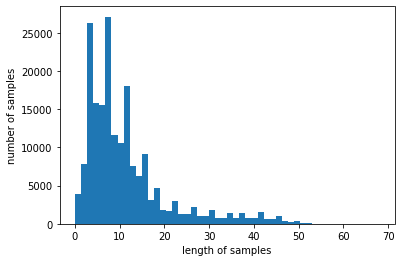

In [55]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## Word2Vec 훈련시키기
- size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
- window = 컨텍스트 윈도우 크기
- min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
- workers = 학습을 위한 프로세스 수
- sg = 0은 CBOW, 1은 Skip-gram.

In [56]:
from gensim.models import Word2Vec
model = Word2Vec(
    sentences = tokenized_data, 
    size = 100,
    window=5, min_count=5, workers = 4, sg = 0
    )

In [57]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16414, 100)

In [58]:
model.wv.most_similar("최민식")

[('박중훈', 0.8765701055526733),
 ('안성기', 0.8572593331336975),
 ('크로우', 0.8376038074493408),
 ('윤제문', 0.8335667848587036),
 ('주진모', 0.8329790234565735),
 ('한석규', 0.830085277557373),
 ('크리스찬', 0.8256165981292725),
 ('혼신', 0.8254762887954712),
 ('유다인', 0.8248376846313477),
 ('공리', 0.8246610164642334)]

In [59]:
model.wv.most_similar("히어로")


[('슬래셔', 0.8429208993911743),
 ('무협', 0.8369538187980652),
 ('호러', 0.8200795650482178),
 ('느와르', 0.818346381187439),
 ('좀비', 0.8142341375350952),
 ('정통', 0.8094519376754761),
 ('물', 0.8007656335830688),
 ('홍콩', 0.7778234481811523),
 ('헐리우드', 0.7729333639144897),
 ('첩보', 0.7682572603225708)]